# Project 3 Team 5
## Date: 17 January 2025 

1. Project Overview
2. Data Load and preprocessing
3. Model training
4. Evaluation
5. Deployment

### 1. Project Overview

### 2. Data load and preprocessing 
#### Packages

In [ ]:
pip install scikeras

In [ ]:
pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from urllib.parse import urlparse
import re
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
import scikeras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, normalize
from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

#### Datasets

In [7]:
#importing the dataset:the train dataset 
train_df = pd.read_csv("Data/processed/train.csv")
# train_df.head(5)

In [9]:
#importing the dataset: the test 
test_df = pd.read_csv("Data/processed/test.csv")
# test_df.head(5)

#### 2.1 Data inspection

In [ ]:
print("The dimensions for the Train set are:", train_df.shape)
print("The dimensions for the test set are:",test_df.shape)

In [ ]:
display(train_df.info(), test_df.info())

There are no missing values in both the train and test dataset

In [ ]:
null_counts = pd.DataFrame({
    "Train Null Count": train_df.isnull().sum(),
    "Test Null Count": test_df.isnull().sum()
})
print(null_counts)

In [ ]:
display(train_df.duplicated().sum(), test_df.duplicated().sum())

Number of duplicate for train set rows: 0

Number of duplicate for test set rows: 0

In [ ]:
def inspect_dataset(df):
    return {
        "Number of Rows": df.shape[0],
        "Number of Columns": df.shape[1],
        "Total Missing Values": df.isnull().sum().sum(),
        "Duplicate Rows": df.duplicated().sum(),
        "Numerical Columns": df.select_dtypes(include='number').shape[1],
        "Categorical Columns": df.select_dtypes(include='object').shape[1],
    }

train_inspection = inspect_dataset(train_df)
test_inspection = inspect_dataset(test_df)

inspection_results = pd.DataFrame({
    "Metric": train_inspection.keys(),
    "Train Dataset": train_inspection.values(),
    "Test Dataset": test_inspection.values(),
})

print(inspection_results)

In [ ]:
train_df.describe().T
#check if there are duplicates 

In [ ]:
categories = train_df.category.unique()
print(test_df.head())

<h3>2.2. Data Preprocessing</h3>

<h4> Preprocessing function that tokenizes, removes stop words and lematizes the text</h4>

In [11]:
def preprocess_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    no_stop_words = [word for word in tokens if word.lower() not in stop_words]

    # Remove punctuation
    no_puntuation = [word for word in no_stop_words if word.isalnum()]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in no_puntuation]

    # Join tokens back into a single string
    return ' '.join(lemmatized_tokens)


In [13]:
columns_to_process = ['headlines', 'description', 'content'] #We will deal with URLs later

for col in columns_to_process:
    train_df[col] = train_df[col].apply(preprocess_text)
    test_df[col] = test_df[col].apply(preprocess_text)

In [ ]:
print(train_df.head())
print(test_df.head())

<h4>2.2.4. Handling URLs</h4>

Some URLs tend to have the category of the article in them while some don't the following code will be used to extract that URL in the case that the category is there, and leave "uncategorised" if there is no category 

In [15]:
# Getting the categories from our data frames
train_categories_df = pd.DataFrame({'category': train_df.category.unique()})

# Converting the category column to a set for faster lookup
predefined_categories = set(train_categories_df['category'].str.lower())


In [17]:
def extract_category(url):
    
    # Parsing the URL to extract the path
    parsed_url = urlparse(url)
    path = parsed_url.path.strip('/')

    # Splitting the path into segments
    path_segments = path.split('/')

    # Defining a default category in case there is no clear category found within the URL
    default_category = 'uncategorized'

    # Checking if the URL contains the word 'article' and extracting the category 
    if 'article' in path_segments:
        
        # Finding the position of 'article' and assume the next segment is the category
        #This is for the URLs that have the category directly after the '/article/' in the URL
        index = path_segments.index('article')
        if index + 1 < len(path_segments):
            category = path_segments[index + 1].lower()
            if category in predefined_categories:
                return category
    
    # Check for cases where the category is not directly after 'article', or if 'article' is missing
    for segment in path_segments:
        # Match alphanumeric categories and check against predefined categories
        category = segment.lower()
        if re.match(r'^[a-zA-Z\-]+$', category) and category in predefined_categories:
            return category

    # Return the default category if no category is found
    return default_category

In [19]:
train_df['url'] = train_df['url'].apply(extract_category)
test_df['url'] = test_df['url'].apply(extract_category)

#The URL columns may not always reliably provide information on the category, so we drop the column
train_df = train_df.drop(columns='url', axis=1)
test_df = test_df.drop(columns='url', axis=1)

train_df.head()

,headlines,description,content,category
0,RBI revise definition person KYC purpose,central bank also asked chairperson chief exec...,Reserve Bank India RBI changed definition Pers...,business
1,NDTV Q2 net profit fall Rs crore impacted lowe...,NDTV consolidated revenue operation Rs crore R...,Broadcaster New Delhi Television Ltd Monday re...,business
2,Akasa Air well capitalised grow much faster CE...,initial share sale open public subscription Ju...,Homegrown server maker Netweb Technologies Ind...,business
3,India current account deficit decline sharply ...,current account deficit CAD per cent GDP USD b...,India current account deficit declined sharply...,business
4,States borrowing cost soar highest far fiscal,price shot reflecting overall higher risk aver...,States forced pay nose weekly auction debt Tue...,business


<h4> Vectorizing</h4>

Before performing the train test split, we will use a TF-IDF vectorizer to draw out important words that may help in predicting the category of an article

In [21]:
text_columns = ['headlines', 'description', 'content']

In [23]:
tfidf_vectorizers = {}
vectorized_texts = []

In [25]:
# Initialize TF-IDF Vectorizer for each text column
vectorizers = {col: TfidfVectorizer() for col in text_columns}

# Vectorize train and test data
train_vectorized_dfs = []
test_vectorized_dfs = []

for col in text_columns:
    # Fit the vectorizer on the training data
    vectorizer = vectorizers[col]
    train_vec_data = vectorizer.fit_transform(train_df[col])
    test_vec_data = vectorizer.transform(test_df[col])
    
    # Create DataFrames for the vectorized data
    train_vec_df = pd.DataFrame(train_vec_data.toarray(), columns=[f"{col}_{feat}" for feat in vectorizer.get_feature_names_out()])
    test_vec_df = pd.DataFrame(test_vec_data.toarray(), columns=[f"{col}_{feat}" for feat in vectorizer.get_feature_names_out()])
    
    # Append vectorized DataFrames
    train_vectorized_dfs.append(train_vec_df)
    test_vectorized_dfs.append(test_vec_df)

# Combine vectorized columns and add the target variable
train_vectorized_df = pd.concat(train_vectorized_dfs, axis=1)
train_vectorized_df['category'] = train_df['category']

test_vectorized_df = pd.concat(test_vectorized_dfs, axis=1)
test_vectorized_df['category'] = test_df['category']

# Display the final DataFrame
# train_vectorized_df.head()

<h4>2.3. Train-test split</h4>

Given that the data has already been separated into training and testing data, we will perform a train test split on the training data to create a validation set.

In [27]:
# Perform a train-validation split (e.g., 80% train, 20% validation)
X = train_vectorized_df.drop(columns = ['category'])
y = train_vectorized_df['category']

X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_vectorized_df.drop(columns='category', axis=1)
y_test = test_vectorized_df['category']


<h4>2.4. Handling Class Imbalances</h4> 

Now, we will check if the categories have an equal spread of observations. If there is a class imbalance this can lead to overfitting and models being able to predict the majority categories better, while poorly predicting the minority categories.

In [28]:
#Getting an idea of the counts of each category
y_train.value_counts()

category
education        1246
technology       1010
business          875
entertainment     782
sports            503
Name: count, dtype: int64

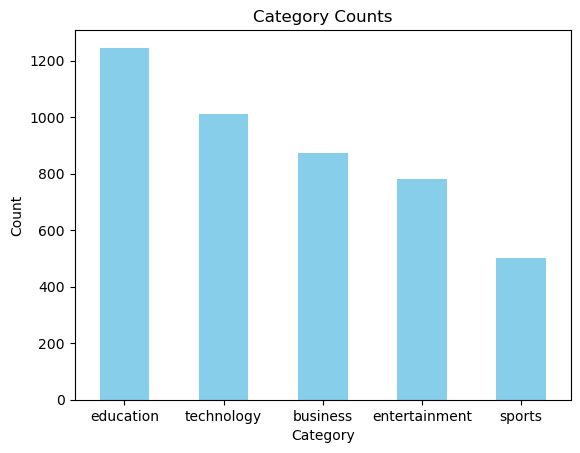

In [241]:
#Storing the count of each category, which will be used later for visualising them
category_counts = y_train.value_counts()

#Plotting a bar graph that shows the differing counts of each category
category_counts.plot(kind='bar', color='skyblue')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


From this bar graph we can clearly see that there is a class imbalance within the training data. If not addressed, this could lead the model to being good at predicting the majority categories (education and technology) and not so much the minorities (sports and entertainment). To ensure that the model is equally effectivce at predicting all the categories, we will implement both upsampling and downsampling on the categories below.

In [31]:
X = train_vectorized_df.drop(columns = ['category'])
y = train_vectorized_df['category']

X.head()

,headlines_007,headlines_10,headlines_100,headlines_100b,headlines_100th,headlines_100x,headlines_101st,headlines_103,headlines_103rd,headlines_1070,...,content_𝗥𝗘𝗣𝗟𝗔𝗬,content_𝗧𝗵𝗮𝘁,content_𝗩𝗶𝗰𝘁𝗼𝗿𝘆,content_𝗪𝗛𝗔𝗧,content_𝗪𝗮𝘀,content_𝗶𝗻,content_𝙈𝘼𝙉,content_𝙈𝘼𝙏𝘾𝙃,content_𝙊𝙁,content_𝙏𝙃𝙀
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
from imblearn.over_sampling import RandomOverSampler

# Apply RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='auto')
X_resampled, y_resampled = oversampler.fit_resample(X, y)

resampled_df = pd.DataFrame(X_resampled, columns=vectorizer.get_feature_names_out())
resampled_df['category'] = y_resampled

over_sampled_df = pd.concat([X_resampled, y_resampled], axis=1)

In [43]:
from imblearn.under_sampling import RandomUnderSampler

target_len = int(len(y_train) / len(y_train.unique()))

X = over_sampled_df.drop(columns = ['category'])
y = over_sampled_df['category']

undersampler = RandomUnderSampler(sampling_strategy={cls: target_len for cls in set(y)})
X_resampled, y_resampled = undersampler.fit_resample(X, y)

resampled_df = pd.DataFrame(X_resampled, columns=vectorizer.get_feature_names_out())
resampled_df['category'] = y_resampled

X_train = X_resampled
y_train = y_resampled

In [44]:
y_train.value_counts()

category
business         883
education        883
entertainment    883
sports           883
technology       883
Name: count, dtype: int64

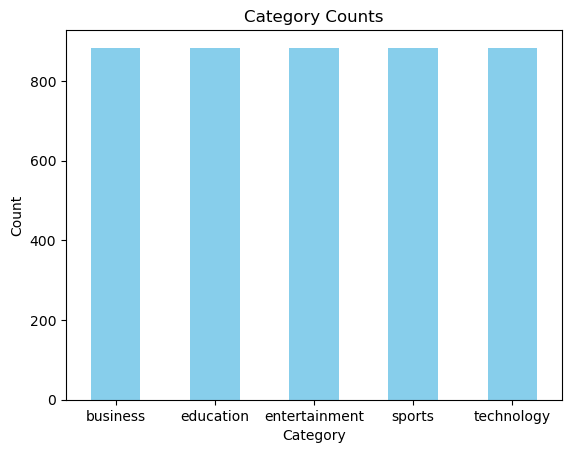

In [45]:
category_counts = y_train.value_counts()

category_counts.plot(kind='bar', color='skyblue')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


As we can see, all the categories have been resampled to where they have the same number of observations.

<h3>Models</h3>

<h4>Neural Network</h4>

In [81]:
#Creating variablex to be used specifically for training the Neural Network
X_train_nn = X_train
y_train_nn = y_train

X_test_nn = X_val
y_test_nn = y_val

In [85]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the training labels and transform them
y_train_nn = label_encoder.fit_transform(y_train_nn)
y_test_nn = label_encoder.transform(y_test_nn)

# Convert to one-hot encoding
y_train_nn = to_categorical(y_train_nn)
y_test_nn = to_categorical(y_test_nn)

In [87]:
num_classes = len(y_train.unique())

model_nn = Sequential([
    Input(shape=(X_train.shape[1],)),  # Input layer matching feature size
    Dense(128, activation='relu'),  # First hidden layer
    Dropout(0.3),  # Regularization
    Dense(64, activation='relu'),  # Second hidden layer
    Dropout(0.2),  # Regularization
    Dense(num_classes, activation='softmax')  # Output layer for classification
])

In [89]:
model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
model_nn.fit(X_train_nn, y_train_nn, validation_data=(X_test_nn, y_test_nn), epochs=10, batch_size=64)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7090 - loss: 1.2605 - val_accuracy: 0.9909 - val_loss: 0.0946
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9944 - loss: 0.0561 - val_accuracy: 0.9928 - val_loss: 0.0284
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9986 - loss: 0.0091 - val_accuracy: 0.9955 - val_loss: 0.0201
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9964 - val_loss: 0.0185
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9955 - val_loss: 0.0182
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9955 - val_loss: 0.0178
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9955 - val_loss: 0.0177
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 1.0000 - loss: 8.4552e-04 - val_accuracy: 0

<h4>Model Evaluation</h4>

In [93]:
test_loss, test_accuracy = model_nn.evaluate(X_test_nn, y_test_nn, batch_size=32)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9967 - loss: 0.0274
Test Loss: 0.018032874912023544
Test Accuracy: 0.9954710006713867


<h4>Model Tuning</h4>

In [95]:
def create_nn_model(optimizer='adam', dropout_rate=0.2, num_units=64):
    model = Sequential([
        Dense(num_units, activation='relu', input_dim=X_train.shape[1]),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    # Compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [97]:
model_nn_tune = KerasClassifier(build_fn=create_nn_model, epochs=10, batch_size=32, verbose=0, dropout_rate=0.2)

In [101]:
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.5],
    'batch_size': [32, 64]
}


Running the following code cell will take a while as it is going a while as it is performing a significant number of tests in an attenmpt to to find the best combination of parameters that will yield the best performing neural network 

In [ ]:
#Using GridSearchCV to get the best hyperparameters for the NN model
grid_search = GridSearchCV(estimator=model_nn_tune, param_grid=param_grid, n_jobs=-1, cv=5)
grid_search.fit(X_train_nn, y_train_nn)

# Get the best hyperparameters
print("Best parameters found: ", grid_search.best_params_)

<h4>Testing the 'best' model</h4>

In [427]:
num_classes = len(y_train.unique())

model_best = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5), 
    Dense(num_classes, activation='softmax') 
])

In [429]:
model_best.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [431]:
model_best.fit(X_train, y_train, validation_data=(X_test_nn, y_test_nn), epochs=10, batch_size=32)

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3662 - loss: 1.5235 - val_accuracy: 0.9158 - val_loss: 0.7972
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.6461 - val_accuracy: 0.9357 - val_loss: 0.2313
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9405 - loss: 0.2273 - val_accuracy: 0.9538 - val_loss: 0.1579
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1678 - val_accuracy: 0.9538 - val_loss: 0.1425
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.1306 - val_accuracy: 0.9538 - val_loss: 0.1383
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9733 - loss: 0.1142 - val_accuracy: 0.9547 - val_loss: 0.1339
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0931 - val_accuracy: 0.9538 - val_loss: 0.1380
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0643 - val_accuracy: 0.

In [433]:
test_loss, test_accuracy = model_best.evaluate(X_test_nn, y_test_nn, batch_size=32)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9499 - loss: 0.1563 
Test Loss: 0.13765276968479156
Test Accuracy: 0.9583333134651184


<h3>Random Forest</h3>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X_train_rf = X_train
y_train_rf = y_train

X_test_rf = X_val
y_test_rf = y_val

# Train and evaluate the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

y_pred = rf_model.predict(X_test_rf)

print("Accuracy Score:", accuracy_score(y_test_nn, y_pred))
print("\nClassification Report:\n", classification_report(y_test_rf, y_pred))


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'bootstrap': [True, False]  # Whether to bootstrap samples
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_rf, y_train_rf)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Use the best model to predict on the test set
best_rf_model = grid_search.best_estimator_
y_pred_optimized = best_rf_model.predict(X_test_rf)

# Evaluate the optimized model
print("\nOptimized Accuracy Score:", accuracy_score(y_test_rd, y_pred_optimized))
print("\nOptimized Classification Report:\n", classification_report(y_test_rf, y_pred_optimized))


In [ ]:
import joblib

# Save the optimized model
joblib.dump(grid_search.best_estimator_, 'optimized_rf_model.pkl')
print("Model saved as 'optimized_rf_model.pkl'")


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test_rf, y_test_rf, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(len(features))
print(len(importances))


In [ ]:
# Trim the importances array to match the number of features
importances = importances[:len(features)]


In [ ]:
# Create the DataFrame with feature names and importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the DataFrame by importance in descending order and take the top 10
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Display the top 10 most important features
print(importance_df)


<h4>KNN</h4>

In [ ]:
X_train_knn = X_train
y_train_knn = y_train

X_test_knn = X_val
y_test_knn = y_val

In [ ]:
# Scale the features
scaler = StandardScaler(with_mean=False)  # Use `with_mean=False` for sparse data
X_train_scaled_knn = scaler.fit_transform(X_train_knn)
X_test_scaled_knn = scaler.transform(X_test_knn)

In [ ]:
# Train the KNN model (multi-label classification assumes one-vs-rest by default)
n_neighbors = 3

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train_scaled_knn, np.argmax(y_train_knn, axis=1)) 

In [ ]:
y_pred_knn = knn.predict(X_test_scaled_knn)

In [ ]:
#For the n neigbors = 3
k_values = [1, 3, 5, 7, 9, 15, 20]

# List to store accuracy scores of each KNN model for comparison
scores = []

# Loop over each value of k 
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train_knn)
    y_pred_knn = knn.predict(X_test_knn)
    accuracy = accuracy_score(y_test_knn, y_pred_knn)
    scores.append(accuracy)
    print(f"Accuracy for K={k}: {accuracy:.4f}")

In [ ]:
k_values = [5, 7, 9]

# List to store metrics for comparison
metrics = {
    'k': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

# Loop over each value of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train_knn)
    
    # Get predictions
    y_pred_knn = knn.predict(X_test_knn)
    
    # Compute metrics
    accuracy = accuracy_score(y_test_knn, y_pred_knn)
    precision = precision_score(y_test_knn, y_pred_knn, average='weighted', zero_division=0)
    recall = recall_score(y_test_knn, y_pred_knn, average='weighted', zero_division=0)
    f1 = f1_score(y_test_knn, y_pred_knn, average='weighted')
    
    # Store the metrics
    metrics['k'].append(k)
    metrics['accuracy'].append(accuracy)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1_score'].append(f1)
    
    # Print metrics for each k
    print(f"\nMetrics for K={k}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Find the best k based on F1 score (or any other metric of choice)
best_k = metrics['k'][np.argmax(metrics['f1_score'])]  # or use np.argmax(metrics['accuracy']) for accuracy
print(f"\nBest performing K: {best_k}")

#unable to the loss log, because imbalance of dimensions

In [ ]:
# Step 2: Define Hyperparameter Ranges for Tuning
param_grid = {
    'n_neighbors': [ 5, 7, 9],          # Number of neighbors
    'weights': ['uniform', 'distance'],      # Weighting scheme
    'metric': ['euclidean', 'manhattan']     # Distance metrics
}

# Step 3: Initialize and Perform Grid Search
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_knn, y_train_knn)

# Step 4: Display the Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

In [ ]:
best_knn = grid_search.best_estimator_
y_test_pred = best_knn.predict(X_test_knn)

print("\nClassification Report (Test Dataset):")
print(classification_report(y_test_knn, y_test_pred))